# Python 105 - Make the SIR model more efficient and add additional parameters

First let's make the model more efficient. Fortunately, after exploring the functions and calculations that make up this model we can quite easily translate the calculations into a more mathematical system which computes much faster! To do this we will use a function provided by the scientific python library scipy which allows us to solve ordinary differential equations (ODEs). Don't worry about the maths terminology, we've actually already done all the solveing, all we need to do is re-write our calculation method to use the more efficient library calculations. 

In [7]:
import pandas as pd  # Loading the NYC dataset 
import numpy as np   # performing fast calculations to build our simulation
import plotly.express as px # Quick visuals for data exploration
from ipywidgets import widgets # sliders, buttons and visual layout of the dashboard
import plotly.graph_objects as go # plotly objects to place on our graph
import math # python mathematical functions
from scipy.integrate import odeint

# We'll set some easy defaults for this function so that we immediately have outputs which make some sense when we execute this method.
def calculate_values_SIR(removal_rate = .1
                         , infection_rate = 1.1
                         , population = 1000
                         , days = 150
                         , initial_infection  = 1
                           
                         
                         # we've added this additional parameter which allows us to cut the 
                         # infection rate by 2 at a given day to simulate drastic policy action.
                         , intervention_day = 50
                         , intervention_effectiveness = .46
                        ):

    # Define a series of ordinary differential equations (math-fancy way of saying equations that model the
    # rate of change of something) notice that all of these values are similar to the ones we were using 
    # before, we're basically going to pass everything from our current method into this method.
    def sir(previous_day
            , day
            , population
            , infection_rate
            , removal_rate
            , intervention_day
            , intervention_effectiveness):
        
        
        # Initialise our values like we previously did. in this Ordinary Differential Equation Solver 
        # these values will correspond to the previous day values.
        susceptible = previous_day[0] + previous_day[3]
        infected = previous_day[1]
        recovered = previous_day[2]
        
        noi_infected = previous_day[1] + previous_day[3]
        noi_removed = previous_day[4]
        
        # Like we did before, check to see if we are past the intervention day, if we are, let's reduce
        # the infection rate by the intervention effectiveness
        if day >= intervention_day:
            inter_infection_rate = infection_rate * max((1-intervention_effectiveness),0)
        else:
            inter_infection_rate = infection_rate
        
        # Calculate our daily changes for each of the categories:
        
        # susceptible
        dsdt = -min(inter_infection_rate * infected * susceptible / population, susceptible) 
        # Infected
        didt = (inter_infection_rate * infected * susceptible / population) - (removal_rate * infected)
        # Removed
        drdt = removal_rate * infected
        
        # If we're after the intervention day, calculate the values as if we had never made an intervention
        if day >= intervention_day:
            
            noi_susceptible = previous_day[0]
            
            noi_dsdt = (min(infection_rate * noi_infected * noi_susceptible / population, noi_susceptible))
            noi_didt =(infection_rate * noi_infected * noi_susceptible / population) - (removal_rate * noi_infected)
            noi_drdt = removal_rate * noi_infected
            
            noi_didt = noi_didt - didt
            noi_drdt = max(noi_drdt - drdt, 0 )
            dsdt = dsdt - noi_didt - noi_drdt
            
        else:
            noi_dsdt = 0
            noi_didt = 0
            noi_drdt = 0
        
        # Return our daily change values
        return [dsdt, didt, drdt, noi_didt, noi_drdt]

    # Set the values we calculate for 
    x_days = np.rint(np.linspace(0,days,days))
    
    # initialize our model with the strting conditions
    starting_condition=[population            # susceptible start
                        , initial_infection   # infection start
                        , 0                   # removed start
                        , 0                   # no intevention infected start
                        , 0]                  # no intervention removed start


    # run a function which will simulate our equation system over a number of 
    # days with our starting positions and the the parameters we give it. 
    # this basically replaces the for loop from our previous implementation.
    s = odeint(sir
               , starting_condition
               , x_days
               , args=(population
                       , infection_rate
                       , removal_rate
                       , intervention_day
                       , intervention_effectiveness))


    # Round our calculated values to integers and then transpose our output 
    # from a list of rows to a list of columns.
    dat = np.rint(s).T
    
    # Return the desired values
    return {'infected': dat[1]
                , 'removed' : dat[2]
                , 'susceptible': dat[0]
                , 'infected_noi': dat[3]
                , 'removed_noi': dat[4] }

## Display the new faster calculation method

Once we've updated the calculation method, we don't need to make any changes to the visualization code from last week, we can take it as is and plug the new calculation method in to use it.

In [8]:
# This slider works with floating point numbers (hence being called Float Slider) and 
# allows us to set a variable with this slider. This is going to be the way we set the 
# infection rate.
ir = widgets.FloatSlider(
                value=1.187, # this is the initial value of our slider when it appears
                min=0.0,     # the minimum value we'll allow
                max=5.0,     # the maximum value we'll allow
                step=.001,   # by what increments the slider will change when we move it
                description='Infection_rate:', # the name of the slider
                continuous_update=True # Will this slider wait until it stops moving to 
                                        # call it's update function or does it call the 
                                        # update function immediately?
)

rr = widgets.FloatSlider(
                value=.46,
                min=0.1,     # this is set to greater than 0 because this is the denominator in the R0 calculation
                max=2.0,
                step=.01,
                description='Removal_Rate:',
                continuous_update=True
)


ii = widgets.IntSlider(
                value=1,
                min=1,
                max=50,
                step=1,
                description='Initially Infected:',
                continuous_update=True
)

ip = widgets.IntSlider(
                value=1000,
                min=500,
                max=10_000_000,
                step=500,
                description='Initial Population:',
                continuous_update=True
)


iday = widgets.IntSlider(
                value=15,
                min=1,
                max=150,
                step=1,
                description='Day of intervention (reducing infection rate):',
                continuous_update=True
)


ie = widgets.FloatSlider(
                value=.46,
                min=0.0,    
                max=1.0,
                step=.01,
                description='Intervention effectiveness:',
                continuous_update=True
)



first_slider_group = widgets.HBox(children=[ir, rr, ie])
second_slider_group = widgets.HBox(children=[ii, ip, iday])

# First, we use the method created above to calculate a model using the initial
# values of the sliders we just created. Given that at this point we haven't 
# displayed the sliders yet, their values will be the default values we set above.

data = calculate_values_SIR(  removal_rate = rr.value
                            , infection_rate = ir.value
                            , population = ip.value
                            , days = 150
                            , initial_infection  = ii.value
                            , intervention_day = iday.value
                        )

# Next we add all the data traces to the chart

infected_trace =  go.Bar(x = list(range(1,len(data['infected'])))
              ,y = data['infected']
              , name='Infected'
              , marker = dict(color='red')
              )

susceptible_trace = go.Bar(x = list(range(1, len(data['susceptible'])))
              , y = data['susceptible']
              , name='Susceptible'
              , marker = dict(color='rgba(0,0,255,0.5)')
              , opacity=0.5
              )

removed_trace = go.Bar(x =list(range(1, len(data['removed'])))
              ,y = data['removed']
              , name='Removed'
              , marker = dict(color='rgba(0,128,0,0.5)')
              , opacity=0.5)


infected_trace_noi =  go.Bar(x = list(range(1,len(data['infected_noi'])))
              ,y = data['infected_noi']
              , name='Infected No Intervention'
              , marker = dict(color='rgba(225,0,0,0.5)')
              )


removed_trace_noi = go.Bar(x =list(range(1, len(data['removed_noi'])))
              ,y = data['removed_noi']
              , name='Removed No Intervention'
              , marker = dict(color='rgba(0,225,0,0.5)')
              )


# This trace is interesting as it's basically just drawing a straight line on the 
# selected intervention day.

intervention_day = go.Scatter(x = [iday.value, iday.value]
              ,y = [0, ip.value]
              , name='Intervention day'
              , marker = dict(color='darkblue')
              , line = dict(width=5)
  )

# We create our figure adding all the traces we created to the data list, and setting some layout values in the layout parameter.
g = go.FigureWidget(data=[ infected_trace, infected_trace_noi, removed_trace, susceptible_trace, intervention_day,  removed_trace_noi ],
                    layout=go.Layout(
                         title={
                                'text': f'R0 = {ir.value / rr.value} <br /> Post-Intervention R0: {ir.value/ 2* rr.value} <br />Infection_rate={ir.value} Removal_rate={rr.value}',
                                'y':.95,
                                'x':0.5,
                                'xanchor': 'center',
                                'yanchor': 'top'}
                        ,barmode='stack'
                        ,hovermode='x'
                        ,height=900
                        ,xaxis=dict(title='Number of Days')
                        ,yaxis=dict(title='Number of People')
                    ))

# This is to update the x-axis range to show only the days where we have cases
g.update_xaxes(range=[0,np.where(data['infected']==0)[0][0]])

x=1

# This method will be called any time one of the sliders is modified. It will re-run our model calculation
# with the new values and update the data for the 4 traces we added to the figure. 
def response(change):

    num_days=150
    
    # recalculate the model using the new values defined by the sliders
    pop_values = calculate_values_SIR(removal_rate = rr.value
                                      , infection_rate=ir.value
                                     , initial_infection=ii.value
                                      , population=ip.value
                                      , days=num_days
                                     , intervention_day = iday.value
                                     , intervention_effectiveness= ie.value
                                     )

    # Try to find the first day where we have no more infections, 
    # if that fails and we get an error, use the maximum number of 
    # days for which we've calculated the model. We use this later 
    # to update the x-axis range to keep our curve centered.
    try:
        end_infection = max( np.where(pop_values['infected_noi'][iday.value+1:]==0)[0][0] + iday.value +1,
                             np.where(pop_values['infected']==0)[0][0] )
    except IndexError:
        end_infection = num_days
    
    # plotly updates much faster if you send all the updates in one go, 
    # this construct allows us to open an update session on our chart
    # and when we leave it, it will send all the updates to the figure 
    # at once.
    with g.batch_update():
        # update the y-axis values from the model
        g.data[0].y = pop_values['infected']
        g.data[1].y = pop_values['infected_noi']
        g.data[2].y = pop_values['removed']
        g.data[3].y = pop_values['susceptible']
        g.data[5].y = pop_values['removed_noi']

        
        # Add the intervention day line
        g.data[4].y = [0         , ip.value]
        g.data[4].x = [iday.value, iday.value]
        
        # update the title to show the R values as well as the infection rate and the removal rate
        
        ie_rate = ir.value * max((1-ie.value),0)
        g.layout.title = {
                        'text': f'R0 = {ir.value / rr.value} <br /> Post-Intervention R0: {ie_rate / rr.value} <br /> Infection_rate={ir.value} Removal_rate={rr.value}',
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'}
        
        # change the x-axis range to keep the infection curve in scope
        g.layout.xaxis = dict(range=[0,end_infection])
        
        
        
        
# Update each of the widgets and register our update method as the method to 
# call when they change.
ir.observe(response, names='value')
rr.observe(response, names='value')
ii.observe(response, names='value')
ip.observe(response, names='value')
iday.observe(response, names='value')
ie.observe(response, names='value')

# put the widgets, and our chart together into our layout
widgets.VBox([first_slider_group, second_slider_group, g])

# Creating the SEIRDS model 

In order to prepare to visualize our SEIRDS model we will need to calculate the number of people in the susceptible, exposed, infectious, deceased, and recovered categories for every single day. Given that we were able to create the previous SIR modle with a series of lists, we can do the same here. In fact, the method we just implemented above makes that very easy for us. 

```
days          --->  [   1,   2,   3,   4,   5,   6,   7,   8,   9, ..... 196 ]
susceptible   --->  [1000, 999, 990, 949, 906, 810, 690, 550, 400, ..... 0   ]
exposed.      --->  [   0,   1,  10,  35,  80, 140, 190, 250, 320, ..... 0   ]
infectious    --->  [   0,   0,   0,   1,   4,  40,  90, 150, 200, ..... 0   ]
recovered     --->  [   0,   0,   0,   5,  10,  20,  30,  50,  80, ..... 900 ]
deceased      --->  [   0,   0,   0,   0,   0,   1,   2,   3,   4, ..... 100 ]
```

All we need to do is set some initial conditions, and identify how to calculate the difference from one day to the next. If we pass that information to the Ordinary Differential Equation solver then it will create the lists for us. Well, it will create a list of daily figures with the numbers for each day (so the transpose of the representation above). We can use that easily by transposing it. 

In [9]:
import pandas as pd  # converting the calculated data into a dataframe for easy display
import numpy as np   # performing fast calculations to build our simulation
import plotly.express as px # Quick visuals for data exploration
from ipywidgets import widgets # sliders, buttons and visual layout of the dashboard
import plotly.graph_objects as go # plotly objects to place on our graph
import math # python mathematical functions
from scipy.integrate import odeint


# We'll set some easy defaults for this function so that we immediately have outputs which make some sense when we execute this method.
def calculate_values_SEIRDS(days_to_recover = 16
                         , infection_rate = 1.1
                         , population = 1000
                         , days = 150
                         , initial_infection  = 1
                         
                         # These parameters will be unused for now, but when we re-add this functionality later 
                         # we can use them to set up our intervention again
                         , intervention_day = 50
                         , intervention_effectiveness = .46
                           
                         # Adding in the incubation period to determine the time it takes for exposure
                         , incubation_period = 14
                           
                         # Adding the fatality rate   
                         , fatality_rate = .01
                           
                         # Adding the immunity period
                         , relapse_period = 180  
                        ):

    # Define a series of ordinary differential equations (math-fancy way of saying equations that model the
    # rate of change of something) notice that all of these values are similar to the ones we were using 
    # before, we're basically going to pass everything from our current method into this method.
    def sir(previous_day
            , day
            , population
            , infection_rate
            , days_to_recover
            , intervention_day
            , intervention_effectiveness
            , incubation_period
            , fatality_rate
            , relapse_period):
        
        susceptible = previous_day[0] 
        exposed = previous_day[1]
        infected = previous_day[2]
        recovered = previous_day[3]
        fatalities = previous_day[4]
        
        incubation = 1/incubation_period
        relapse = 1/relapse_period
        recovery_rate = 1/days_to_recover
        
        
        
        inter_infection_rate = infection_rate
        
        # Daily change in susceptible
        dsdt = -min(inter_infection_rate * infected * susceptible / population, susceptible) + (relapse * recovered)
        
        # Daily change in exposed
        dedt = (inter_infection_rate * infected * susceptible / population) - (incubation * exposed)
        
        # Daily change in infected
        didt = incubation * exposed - (recovery_rate * infected) - (fatality_rate * infected)
        
        # Daily change in recovered
        drdt = recovery_rate * infected - (relapse * recovered)
        
        # Daily change in fatalities
        dfdt = fatality_rate * infected
        
        return [dsdt, dedt, didt, drdt, dfdt]


    x_days = np.rint(np.linspace(0,days,days))
    
    starting_condition=[population            # susceptible start
                        , initial_infection   # exposure start
                        , 0                   # infection start
                        , 0                   # recovered
                        , 0]                  # fatalities


    # run a function which will simulate our equation system over a number of 
    # days with our starting positions and the the parameters we give it. 
    # this basically replaces the for loop from our previous implementation.
    s = odeint(sir
               , starting_condition
               , x_days
               , args=(population
                       , infection_rate
                       , days_to_recover
                       , intervention_day
                       , intervention_effectiveness
                       , incubation_period
                       , fatality_rate
                       , relapse_period))


    # Round our calculated values to integers and then transpose our output 
    # from a list of rows to a list of columns.
    dat = np.rint(s).T
    
    # Return the desired values
    return {  'infected'   : dat[2]
            , 'exposed'    : dat[1]
            , 'recovered'  : dat[3]
            , 'susceptible': dat[0]
            , 'fatalities' : dat[4] }

That was a fair amount of calculation, but really no different from what we were doing last week and the week before. So before we jump into updating our dashboard to handle these new values, let's have a quick look at what they look like to check we're not way off the mark.

In [14]:
df = calculate_values_SEIRDS( days_to_recover = 16
                            , infection_rate = 1.34
                            , population = 7_000_000
                            , days = 600
                            , initial_infection  = 1
#                             , intervention_day = iday.value
                            , fatality_rate = 0.03
                            , relapse_period = 180
                        )

# create a dataframe out of the data we calculated. Note that we have to call reset_index to 
# get a column with the days for the visualization.
pdf = pd.DataFrame(df)
pdf

,infected,exposed,recovered,susceptible,fatalities
0,0.0,1.0,0.0,7000000.0,0.0
1,0.0,1.0,0.0,7000000.0,0.0
2,0.0,1.0,0.0,7000000.0,0.0
3,0.0,1.0,0.0,7000000.0,0.0
4,0.0,1.0,0.0,6999999.0,0.0
...,...,...,...,...,...
595,109454.0,139284.0,1750564.0,464178.0,4536521.0
596,109278.0,139061.0,1747682.0,464177.0,4539802.0
597,109103.0,138838.0,1744805.0,464176.0,4543078.0
598,108928.0,138616.0,1741933.0,464175.0,4546348.0


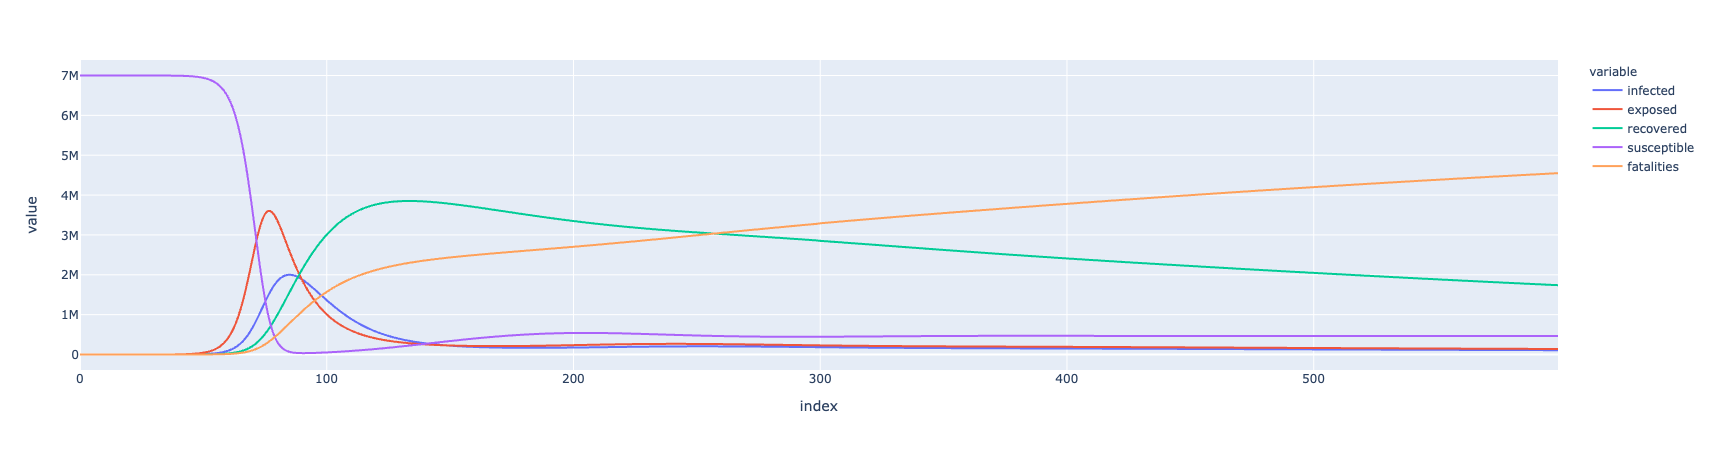

In [15]:
pdf = pdf.reset_index()

# We melt the dataframe (this is basically an unpivot) to make sure that we have one x value and 
# one y value column, we can differentiate between the different groups with the variable column
pdf = pdf.melt(id_vars=['index'])
px.line(pdf, x='index', y='value', color='variable')

The data looks good now we can put all of these plots into our dashboard.

In [5]:
# This slider works with floating point numbers (hence being called Float Slider) and 
# allows us to set a variable with this slider. This is going to be the way we set the 
# infection rate.
ir = widgets.FloatSlider(
                value=1.187, # this is the initial value of our slider when it appears
                min=0.0,     # the minimum value we'll allow
                max=5.0,     # the maximum value we'll allow
                step=.001,   # by what increments the slider will change when we move it
                description='Infection_rate:', # the name of the slider
                continuous_update=True # Will this slider wait until it stops moving to 
                                        # call it's update function or does it call the 
                                        # update function immediately?
)

rr = widgets.IntSlider(
                value=16,
                min=1,     # this is set to greater than 0 because this is the denominator in the R0 calculation
                max=30,
                step=1,
                description='Days to Recover:',
                continuous_update=True
)


ii = widgets.IntSlider(
                value=1,
                min=1,
                max=50,
                step=1,
                description='Initially Infected:',
                continuous_update=True
)

ip = widgets.IntSlider(
                value=7_000_000,
                min=500,
                max=10_000_000,
                step=500,
                description='Initial Population:',
                continuous_update=True
)


iday = widgets.IntSlider(
                value=15,
                min=1,
                max=150,
                step=1,
                description='Day of intervention (reducing infection rate):',
                continuous_update=True
)


ie = widgets.FloatSlider(
                value=.46,
                min=0.0,    
                max=1.0,
                step=.01,
                description='Intervention effectiveness:',
                continuous_update=True
)


fr = widgets.FloatSlider(
                value=.01,
                min=0.0,    
                max=.5,
                step=.001,
                description='Fatality Rate:',
                continuous_update=True
)

relr = widgets.IntSlider(
                value=180,
                min=0.0,    
                max=600,
                step=1,
                description='Immunity Period:',
                continuous_update=True
)


incu = widgets.IntSlider(
                value=14,
                min=0.0,    
                max=30,
                step=1,
                description='Incubation Period:',
                continuous_update=True
)

first_slider_group = widgets.HBox(children=[ir, fr, ip])
second_slider_group = widgets.HBox(children=[rr, relr, incu])
third_slider_group = widgets.HBox(children=[ie, iday])

# First, we use the method created above to calculate a model using the initial
# values of the sliders we just created. Given that at this point we haven't 
# displayed the sliders yet, their values will be the default values we set above.

data = calculate_values_SEIRDS(  days_to_recover = rr.value
                            , infection_rate = ir.value
                            , population = ip.value
                            , days = 200
                            , initial_infection  = ii.value
                            , intervention_day = iday.value
                            , fatality_rate= fr.value
                            , relapse_period=relr.value
                            , incubation_period=incu.value
                        )

# Next we add all the data traces to the chart

infected_trace =  go.Bar(x = list(range(1,len(data['infected'])))
              ,y = data['infected']
              , name='Infected'
              , marker = dict(color='red')
              )

susceptible_trace = go.Bar(x = list(range(1, len(data['susceptible'])))
              , y = data['susceptible']
              , name='Susceptible'
              , marker = dict(color='rgba(0,0,255,0.5)')
              , opacity=0.5
              )

removed_trace = go.Bar(x =list(range(1, len(data['recovered'])))
              ,y = data['recovered']
              , name='Recovered'
              , marker = dict(color='rgba(0,128,0,0.5)')
              , opacity=0.5)

######
# ADDITION STARTS HERE
######


exposed_trace =  go.Bar(x = list(range(1,len(data['exposed'])))
              ,y = data['exposed']
              , name='Exposed'
              , marker = dict(color='rgba(125,125,0,0.5)')
              )


fatality_trace = go.Bar(x =list(range(1, len(data['fatalities'])))
              ,y = data['fatalities']
              , name='Fatalities'
              , marker = dict(color='rgba(115,115,115,0.5)')
              )

######
# ADDITION END HERE
######


# This trace is interesting as it's basically just drawing a straight line on the 
# selected intervention day.

# intervention_day = go.Scatter(x = [iday.value, iday.value]
#               ,y = [0, ip.value]
#               , name='Intervention day'
#               , marker = dict(color='darkblue')
#               , line = dict(width=5)
#   )

ie_rate = ir.value * max((1-ie.value),0)
rr_rate = fr.value + (1/np.sqrt(rr.value)) + (1/incu.value)  
# We create our figure adding all the traces we created to the data list, and setting some layout values in the layout parameter.
g = go.FigureWidget(data=[fatality_trace, infected_trace, exposed_trace,  removed_trace, susceptible_trace], 
                    layout=go.Layout(
                         title={
                                'text': f' Infection_rate={ir.value} Days to recover={rr.value}',
                                'y':.95,
                                'x':0.5,
                                'xanchor': 'center',
                                'yanchor': 'top'}
                        ,barmode='stack'
                        ,hovermode='x'
                        ,height=900
                        ,xaxis=dict(title='Number of Days')
                        ,yaxis=dict(title='Number of People')
                    ))

# This is to update the x-axis range to show only the days where we have cases
try:
    rng = [0,np.where(data['exposed'][:1]==0)[0][0]]
except:
    rng = [0,len(data['exposed'])]

g.update_xaxes(range=rng)

x=1

# This method will be called any time one of the sliders is modified. It will re-run our model calculation
# with the new values and update the data for the 4 traces we added to the figure. 
def response(change):

    num_days=200
    
    # recalculate the model using the new values defined by the sliders
    pop_values = calculate_values_SEIRDS(days_to_recover = rr.value
                                      , infection_rate=ir.value
                                     , initial_infection=ii.value
                                      , population=ip.value
                                      , days=num_days
                                     , intervention_day = iday.value
                                     , intervention_effectiveness= ie.value
                                     , fatality_rate= fr.value
                                     , relapse_period=relr.value
                                     , incubation_period=incu.value
                                     )

    # Try to find the first day where we have no more infections, 
    # if that fails and we get an error, use the maximum number of 
    # days for which we've calculated the model. We use this later 
    # to update the x-axis range to keep our curve centered.
    try:
        end_infection = np.where(pop_values['exposed'][1:]==0)[0][0] 
    except IndexError:
        end_infection = num_days
    
    
    
    
    # plotly updates much faster if you send all the updates in one go, 
    # this construct allows us to open an update session on our chart
    # and when we leave it, it will send all the updates to the figure 
    # at once.
    with g.batch_update():
        # update the y-axis values from the model, we changed the order above so we need to adapt it here
        # [fatality_trace, infected_trace, exposed,  removed_trace, susceptible_trace, intervention_day ]
        # ------ 0 ------- --- 1 -------- -- 2 ---- ------- 3 ---- -------- 4 ------- ------- 5 -------
        g.data[0].y = pop_values['fatalities']
        g.data[1].y = pop_values['infected']
        g.data[2].y = pop_values['exposed']
        g.data[3].y = pop_values['recovered']
        g.data[4].y = pop_values['susceptible']

        
        # Add the intervention day line
#         g.data[5].y = [0         , ip.value]
#         g.data[5].x = [iday.value, iday.value]
        
        # update the title to show the R values as well as the infection rate and the removal rate
        
        ie_rate = ir.value * max((1-ie.value),0)
        rr_rate = fr.value + (1/np.sqrt(rr.value)) + (1/incu.value)  
        g.layout.title = {
                        'text': f' Infection_rate={ir.value} Days to recover={rr.value}',
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'}
        
        # change the x-axis range to keep the infection curve in scope
        g.layout.xaxis = dict(range=[0,end_infection])
        
        
        
        
# Update each of the widgets and register our update method as the method to 
# call when they change.
ir.observe(response, names='value')
rr.observe(response, names='value')
ii.observe(response, names='value')
ip.observe(response, names='value')
iday.observe(response, names='value')
ie.observe(response, names='value')

fr.observe(response, names='value')
relr.observe(response, names='value')
incu.observe(response, names='value')

# put the widgets, and our chart together into our layout
widgets.VBox([first_slider_group, second_slider_group, g])

# Challenge (Hard): Add notion of intervention day to the SEIRDS model

This is a hard challenge, can you add the concept of an intervention day to the SEIRDS model? some of the peices are already there, you'll need to modify the model to take into account the intervention day in the same way that we did for the SIR model.


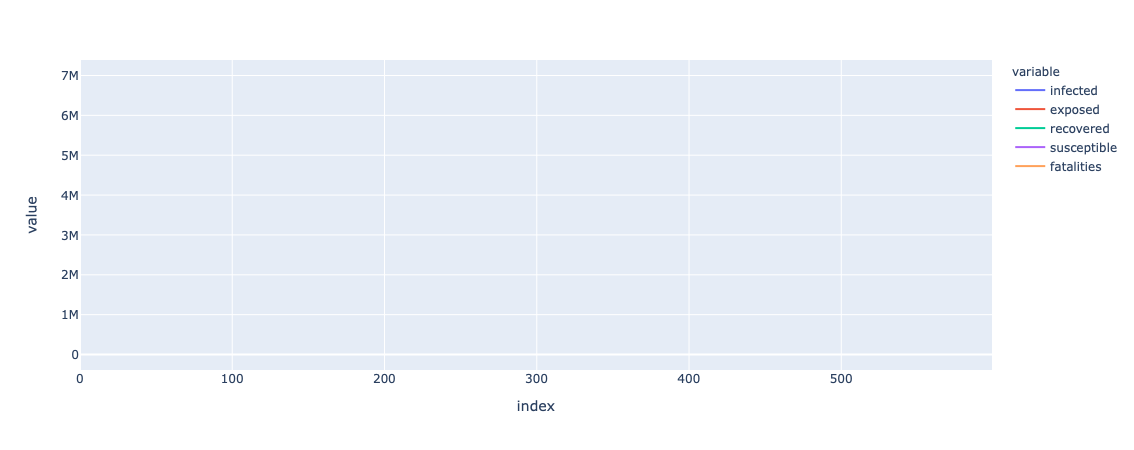

In [6]:
import pandas as pd  # Loading the NYC dataset 
import numpy as np   # performing fast calculations to build our simulation
import plotly.express as px # Quick visuals for data exploration
from ipywidgets import widgets # sliders, buttons and visual layout of the dashboard
import plotly.graph_objects as go # plotly objects to place on our graph
import math # python mathematical functions
from scipy.integrate import odeint


# We'll set some easy defaults for this function so that we immediately have outputs which make some sense when we execute this method.
def calculate_values_SEIRS(days_to_recover = 16
                         , infection_rate = 1.1
                         , population = 1000
                         , days = 150
                         , initial_infection  = 1
                         
                         # These parameters will be unused for now, but when we re-add this functionality later 
                         # we can use them to set up our intervention again
                         , intervention_day = 50
                         , intervention_effectiveness = .46
                           
                         # Adding in the incubation period to determine the time it takes for exposure
                         , incubation_period = 14
                           
                         # Adding the fatality rate   
                         , fatality_rate = .01
                           
                         # Adding the immunity period
                         , relapse_period = 180  
                        ):

    # Define a series of ordinary differential equations (math-fancy way of saying equations that model the
    # rate of change of something) notice that all of these values are similar to the ones we were using 
    # before, we're basically going to pass everything from our current method into this method.
    def sir(previous_day
            , day
            , population
            , infection_rate
            , days_to_recover
            , intervention_day
            , intervention_effectiveness
            , incubation_period
            , fatality_rate
            , relapse_period):
        
        susceptible = previous_day[0] 
        exposed = previous_day[1]
        infected = previous_day[2]
        recovered = previous_day[3]
        fatalities = previous_day[4]
        
        incubation = 1/incubation_period
        relapse = 1/relapse_period
        recovery_rate = 1/days_to_recover
        
        
        
        if day >= intervention_day:
            inter_infection_rate = infection_rate * max((1-intervention_effectiveness),0)
        else:
            inter_infection_rate = infection_rate
        
        # Daily change in susceptible
        dsdt = -min(inter_infection_rate * infected * susceptible / population, susceptible) + (relapse * recovered)
        
        # Daily change in exposed
        dedt = (inter_infection_rate * infected * susceptible / population) - (incubation * exposed)
        
        # Daily change in infected
        didt = incubation * exposed - (recovery_rate * infected) - (fatality_rate * infected)
        
        # Daily change in recovered
        drdt = recovery_rate * infected - (relapse * recovered)
        
        # Daily change in fatalities
        dfdt = fatality_rate * infected
        
        
#         if day >= intervention_day:
            
#             noi_susceptible = previous_day[0]
            
#             noi_dsdt = (min(infection_rate * noi_infected * noi_susceptible / population, noi_susceptible))
#             noi_didt =(infection_rate * noi_infected * noi_susceptible / population) - (removal_rate * noi_infected)
#             noi_drdt = removal_rate * noi_infected
            
#             noi_didt = noi_didt - didt
#             noi_drdt = max(noi_drdt - drdt, 0 )
#             dsdt = dsdt - noi_didt - noi_drdt
            
#         else:
#             noi_dsdt = 0
#             noi_didt = 0
#             noi_drdt = 0
        
        
        
        return [dsdt, dedt, didt, drdt, dfdt]


    x_days = np.rint(np.linspace(0,days,days))
    
    starting_condition=[population            # susceptible start
                        , initial_infection   # exposure start
                        , 0                   # infection start
                        , 0                   # recovered
                        , 0]                  # fatalities


    # run a function which will simulate our equation system over a number of 
    # days with our starting positions and the the parameters we give it. 
    # this basically replaces the for loop from our previous implementation.
    s = odeint(sir
               , starting_condition
               , x_days
               , args=(population
                       , infection_rate
                       , days_to_recover
                       , intervention_day
                       , intervention_effectiveness
                       , incubation_period
                       , fatality_rate
                       , relapse_period))


    # Round our calculated values to integers and then transpose our output 
    # from a list of rows to a list of columns.
    dat = np.rint(s).T
    
    # Return the desired values
    return {  'infected'   : dat[2]
            , 'exposed'    : dat[1]
            , 'recovered'  : dat[3]
            , 'susceptible': dat[0]
            , 'fatalities' : dat[4] }



df = calculate_values_SEIRS( days_to_recover = 16
                            , infection_rate = ir.value
                            , population = 7_000_000
                            , days = 600
                            , initial_infection  = ii.value
                            , intervention_day = iday.value
                            , fatality_rate = 0.03
                            , relapse_period = 180
                        )

pdf = pd.DataFrame(df).reset_index()
pdf = pdf.melt(id_vars=['index'])
px.line(pdf, x='index', y='value', color='variable')


# Challenge (Very Hard): Draw the situation without intervention on the graph

Can you add in the same hypothetical scenarios as we had in the SIR model to the graph?

## Easter Egg: Can you find the bug in the model which spawns extra people? Can you explain why that is happening?